In [1]:
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,UpSampling2D,Reshape,Concatenate
from keras.models import Model
from keras import backend as K
from struct import unpack
import json
import glob
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import numpy as np
from io import BytesIO
import PIL
from PIL import ImageDraw
from keras.utils import get_file
from IPython.display import clear_output,Image,display,HTML

In [2]:
from tensorflow.keras.utils import load_img, img_to_array

In [3]:
labels = ['camel','cat','cow','dog','horse','lion','mouse','pig','rabbit','sheep','tiger','zebra']
labels_to_idx = {label:idx for idx,label in enumerate(labels)}
base_url = 'https://storage.googleapis.com/quickdraw_dataset/full/binary/%s.bin'
paths = {label:get_file(label+'.bin',base_url % label) for label in labels}
paths

25074676/25074676 [==============================] - 1s 0us/step


{'camel': '/home/datalore/.keras/datasets/camel.bin',
 'cat': '/home/datalore/.keras/datasets/cat.bin',
 'cow': '/home/datalore/.keras/datasets/cow.bin',
 'dog': '/home/datalore/.keras/datasets/dog.bin',
 'horse': '/home/datalore/.keras/datasets/horse.bin',
 'lion': '/home/datalore/.keras/datasets/lion.bin',
 'mouse': '/home/datalore/.keras/datasets/mouse.bin',
 'pig': '/home/datalore/.keras/datasets/pig.bin',
 'rabbit': '/home/datalore/.keras/datasets/rabbit.bin',
 'sheep': '/home/datalore/.keras/datasets/sheep.bin',
 'tiger': '/home/datalore/.keras/datasets/tiger.bin',
 'zebra': '/home/datalore/.keras/datasets/zebra.bin'}

In [4]:
def load_icons(paths, train_size=0.85, max_per_class=10000):
    x = []
    y = []
    for label, path in paths.items():
        with open(path, 'rb') as f:
            while True:
                img = PIL.Image.new('L', (32, 32), 'white')
                draw = ImageDraw.Draw(img)
                header = f.read(15)
                if len(header) != 15:
                    break
                strokes, = unpack('H', f.read(2))
                for i in range(strokes):
                    n_points, = unpack('H', f.read(2))
                    fmt = str(n_points) + 'B'
                    read_scaled = lambda: (p // 8 for 
                                           p in unpack(fmt, f.read(n_points)))
                    points = [*zip(read_scaled(), read_scaled())]
                    draw.line(points, fill=0)
                img = img_to_array(img)
                x.append(img)
                y.append(labels_to_idx[label])
                if len(x) % max_per_class == 0:
                    break
    x = np.asarray(x) / 255
    y = np.asarray(y)
    return train_test_split(x, y, train_size=train_size)


x_train, x_test, y_train, y_test = load_icons(paths)
x_train.shape, x_test.shape

((102000, 32, 32, 1), (18000, 32, 32, 1))

In [5]:
def create_autoencoder():
    input_img = Input(shape=(32,32,1))

    channels = 4
    x = input_img
    for i in range(4):
        left = Conv2D(channels,(3,3),activation='relu', padding='same')(x)
        right = Conv2D(channels,(2,2),activation='relu', padding='same')(x)
        conc = Concatenate()([left,right])
        x = MaxPooling2D((2,2),padding='same')(conc)
        channels *= 2
    
    x = Dense(32)(x)
    #reprezentacja 128 wymiarowa

    x = Conv2D(32,(3,3),activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(16,(3,3),activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(8,(3,3),activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(4,(3,3),activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)

    decoded = Conv2D(1,(3,3),activation='sigmoid', padding = 'same')(x)

    autoencoder = Model(input_img,decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder
autoencoder = create_autoencoder()
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 4)    40          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 4)    20          ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 32, 32, 8)    0           ['conv2d[0][0]',                 
                                                                  'conv2d_1[0][0]']           

In [6]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train,x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test,x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 92/100
797/797 [==============================] - 306s 384ms/step - loss: 0.3439 - val_loss: 0.3432
Epoch 93/100
797/797 [==============================] - 313s 393ms/step - loss: 0.3437 - val_loss: 0.3430
Epoch 94/100
797/797 [==============================] - 350s 439ms/step - loss: 0.3435 - val_loss: 0.3428
Epoch 95/100
797/797 [==============================] - 378s 474ms/step - loss: 0.3433 - val_loss: 0.3425
Epoch 96/100
797/797 [==============================] - 374s 469ms/step - loss: 0.3430 - val_loss: 0.3423
Epoch 97/100
797/797 [==============================] - 383s 480ms/step - loss: 0.3428 - val_loss: 0.3421
Epoch 98/100
797/797 [==============================] - 301s 378ms/step - loss: 0.3426 - val_loss: 0.3419
Epoch 99/100
797/797 [==============================] - 318s 399ms/step - loss: 0.3424 - val_loss: 0.3417
Epoch 100/100
797/797 [==============================] - 360s 451ms/step - loss: 0.3422 - val_loss: 0.3414


In [10]:
cols = 25
idx = np.random.randint(x_test.shape[0], size=cols)
sample = x_test[idx]
decoded_imgs = autoencoder.predict(sample)
decoded_imgs.shape

1/1 [==============================] - 0s 36ms/step


(25, 32, 32, 1)

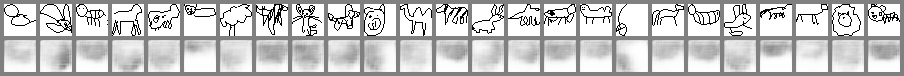

In [11]:
def decode_img(tile):
    tile = tile.reshape(tile.shape[:-1])
    tile = np.clip(tile * 255, 0, 255)
    return PIL.Image.fromarray(tile)
    

overview = PIL.Image.new('RGB', (cols * 36 + 4, 64 + 12), (128, 128, 128))
for idx in range(cols):
    overview.paste(decode_img(sample[idx]), (idx * 36 + 4, 4))
    overview.paste(decode_img(decoded_imgs[idx]), (idx * 36 + 4, 40))
f = BytesIO()
overview.save(f, 'png')
display(Image(data=f.getvalue()))